In [48]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt
%matplotlib inline

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)
import data_prep_pyn as dpp

import pynapple as nap
from sklearn.cluster import KMeans,AgglomerativeClustering
import database
db = database.db

In [2]:
import ruptures as rpt

import nmf_test as nt

In [104]:
db

data_dir_full  \
animal_name                                                        
e13_16f1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            4  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
...                                                          ...   
IZ32        0  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
IZ33        0  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            1  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            2  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            3  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   

                              sess_name animal_name.1        date  \
animal_name                                                         
e13_16f1    0           e13_16f1_210302      e13_16f1  2021-03-02   
            1           e13_16f1_210312      e13_16f1  2021-03-12   
            2           e13_16f1_210314      e13_16f1  2021-03-14   
            3           e13_16f1_210315      e13_16f1  2021-03-15   
            4           e13_16f1_210317      e13_16f1  2021-03-17   
...                                 ...           ...         ...   
IZ32        0  IZ32_1008um_210303_sess7          IZ32  2021-03-03   
IZ33        0   IZ33_580um_210312_sess8          IZ33  2021-03-12   
            1   IZ33_580um_210315_sess9          IZ33  2021-03-15   
            2  IZ33_580um_210317_sess10          IZ33  2021-03-17   
            3  IZ33_580um_210319_sess11          IZ33  2021-03-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_16f1    0                    alternation     0.571429       21   
            1                    alternation     0.950000       20   
            2                    alternation     0.875000       24   
            3                    alternation     0.789474       19   
            4                    alternation     0.875000       24   
...                                      ...          ...      ...   
IZ32        0  ['alternation' 'alternation']     0.833333      102   
IZ33        0  ['alternation' 'alternation']     0.841463       82   
            1  ['alternation' 'alternation']     0.829268       82   
            2  ['alternation' 'alternation']     0.804878       82   
            3  ['alternation' 'alternation']     0.795181       83   

               ngoodtrials  n_neurons  n_pyr_putative    owner     data_root  
animal_name                                                                   
e13_16f1    0           21        135             114    roman    roman_data  
            1           20        124             105    roman    roman_data  
            2           24        121             102    roman    roman_data  
            3           19        114              92    roman    roman_data  
            4           24        130             112    roman    roman_data  
...                    ...        ...             ...      ...           ...  
IZ32        0          102         89              76  ipshita  ipshita_data  
IZ33        0           82        180             120  ipshita  ipshita_data  
            1           82        143              77  ipshita  ipshita_data  
            2           82        169             106  ipshita  ipshita_data  
            3           83        152              95  ipshita  ipshita_data  

[72 rows x 12 columns]

In [106]:
# data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full=db.loc['e15_13f1']['data_dir_full'][0]
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117'

In [107]:
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
behavior=mat_to_return['behavior']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']

load *SessionPulses.Events.mat failed


In [108]:
fr_pyr = spk_beh_df.loc[:,list(cell_cols_d['pyr'])+list(beh_df.columns)]
# convert to rate (Hz):
dt = np.median(np.diff(beh_df.index))
fr_pyr.loc[:,cell_cols_d['pyr']] = fr_pyr.loc[:,cell_cols_d['pyr']]/dt
speed_thresh=1.
nbins=10
# bin coarsely by lin
fr_filtered = copy.copy(fr_pyr.query("(speed>=@speed_thresh)"))
fr_filtered['lin_binned'] = pd.cut(fr_filtered['lin'],nbins,retbins=False,labels=False)

In [109]:
trialtype_key_dict = dpp.TRIALTYPE_KEY_DICT
task_index_to_task_name = dpp.get_task_index_to_task_name(spk_beh_df)

# nmf
# W_df_d,W_sorted_d,H_sorted_d,W_df_peaks_only_d,W_df_original_d,X_normed_restacked_df_d = {},{},{},{},{},{}
X_restacked_df_d = {}
X_normed_restacked_df_d={}

max_fr_thresh = 1.
n_compo = 4

for task_type, fr_filtered_task in fr_filtered.groupby('task_index'):
    trialtype_key=trialtype_key_dict[task_index_to_task_name[task_type]] # visitedArm or direction
    for trial_type, fr_filtered_task_trialtype in fr_filtered_task.groupby(trialtype_key):
        fr_to_be_nmfed_one_trialtype = fr_filtered_task_trialtype.groupby(['trial','lin_binned'])[cell_cols_d['pyr']].mean()
        X_restacked_df = na.preprocess_for_nmf_with_position(fr_to_be_nmfed_one_trialtype,do_normalize=False)
        X_restacked_df_d[(task_type,trial_type)] = X_restacked_df
        X_normed_restacked_df = na.preprocess_for_nmf_with_position(fr_to_be_nmfed_one_trialtype,do_normalize=True)
        X_normed_restacked_df_d[(task_type,trial_type)] = X_normed_restacked_df

/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:39: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant


In [80]:
from scipy.spatial.distance import pdist, squareform
from sklearn.mixture import GaussianMixture 

In [118]:
n_clust = 8
clust_d = {}
for k,val in X_restacked_df_d.items():
# for k,val in X_normed_restacked_df_d.items():
#     model=KMeans(n_clusters=n_clust)
    model = GaussianMixture(n_components=8)

    clust=model.fit_predict(val)
    clust = pd.Series(clust,index=val.index)
    clust_d[k] = clust

In [119]:
key = (0,0)
X_with_clust = copy.copy(X_restacked_df_d[key])
# X_with_clust = copy.copy(X_normed_restacked_df_d[key])
X_with_clust['clust'] = clust_d[key]

<AxesSubplot:xlabel='trial'>

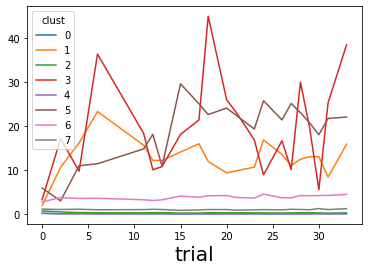

In [120]:
X_with_clust.groupby('clust').mean().T.plot()

<AxesSubplot:xlabel='trial'>

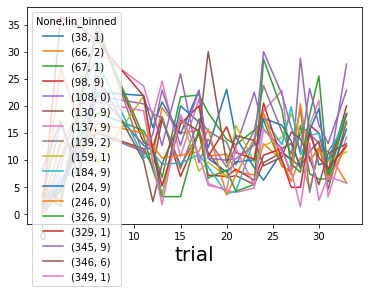

In [126]:
clust=1
trial_cols = X_with_clust.columns[X_with_clust.columns!='clust']
X_with_clust.query('clust==@clust').loc[:,trial_cols].T.plot()

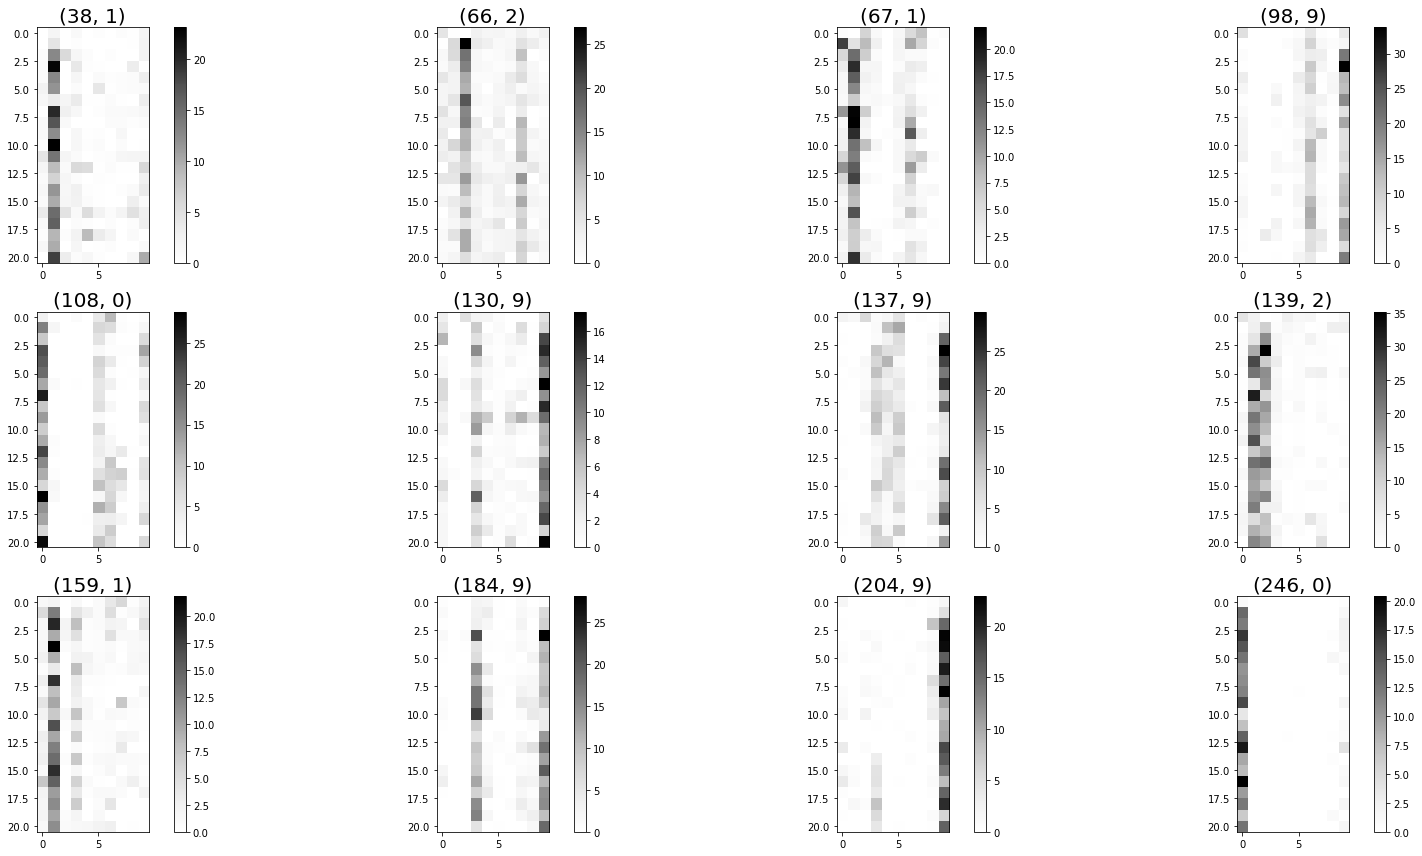

In [127]:
index_list = X_with_clust.query('clust==@clust').index[:12]
nplots = len(index_list)
fig,axs = ph.subplots_wrapper(nplots,return_axs=True)
for ii,ind in enumerate(index_list):
    ax =axs.ravel()[ii]
    im=ax.imshow(X_with_clust.loc[ind[0],trial_cols].T)
    plt.colorbar(im,ax=ax)
    ax.set_title(ind)
plt.tight_layout()

In [8]:
X_restacked_df_d[0,0]

trial               0.0       1.0       4.0       6.0       7.0       8.0   \
    lin_binned                                                               
1   0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    1           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    3           0.000000  0.175439  0.000000  0.000000  0.000000  0.000000   
    4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
135 5           1.666667  2.228571  1.075697  0.981818  0.876404  1.245283   
    6           3.009118  3.195876  1.794872  2.834646  2.250000  2.593320   
    7           0.625000  0.504202  1.818182  1.276596  0.000000  0.000000   
    8           1.704545  0.638298  0.596026  0.000000  0.220588  0.000000   
    9           0.000000  0.731707  3.901734  4.844720  0.750000  0.000000   

trial               10.0      11.0      12.0      14.0      15.0      16.0  \
    lin_binned                                                               
1   0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    1           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
135 5           2.209821  2.812500  1.924939  1.841584  2.681564  2.996005   
    6           3.766234  2.142857  2.135922  3.175182  2.075782  3.566433   
    7           0.000000  0.882353  0.333333  0.662983  0.631579  2.238806   
    8           0.468750  0.236220  0.180180  0.166667  0.000000  0.000000   
    9           1.818182  1.803279  1.010101  1.380753  0.000000  0.000000   

trial               18.0      20.0      21.0  
    lin_binned                                
1   0           0.000000  0.000000  0.282353  
    1           0.000000  0.000000  0.000000  
    2           0.000000  0.000000  0.000000  
    3           0.000000  0.000000  0.000000  
    4           0.000000  0.000000  0.000000  
...                  ...       ...       ...  
135 5           2.262570  2.350230  1.382979  
    6           3.567567  2.806452  0.974026  
    7           0.379747  2.000000  0.909091  
    8           0.267857  0.000000  0.000000  
    9           0.344828  0.000000  0.327273  

[1140 rows x 15 columns]